Saving Locust_2025-05-16-18h13_locustfile.py_http___localhost_8000_exceptions.csv to Locust_2025-05-16-18h13_locustfile.py_http___localhost_8000_exceptions (2).csv
Saving Locust_2025-05-16-18h13_locustfile.py_http___localhost_8000_failures.csv to Locust_2025-05-16-18h13_locustfile.py_http___localhost_8000_failures (2).csv
Saving Locust_2025-05-16-18h13_locustfile.py_http___localhost_8000_requests.csv to Locust_2025-05-16-18h13_locustfile.py_http___localhost_8000_requests (2).csv

TEMEL PERFORMANS ISTATISTIKLERI
| Name            |   Request Count |   Failure Count |   Median Response Time |   Average Response Time |   Requests/s |
|:----------------|----------------:|----------------:|-----------------------:|------------------------:|-------------:|
| /generate_async |            1006 |               0 |                 105000 |                  103105 |     0.763106 |
| /generate_sync  |            1069 |               0 |                  20000 |                   21223 |     0.8108

<ipython-input-2-418ceb3c1bab>:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


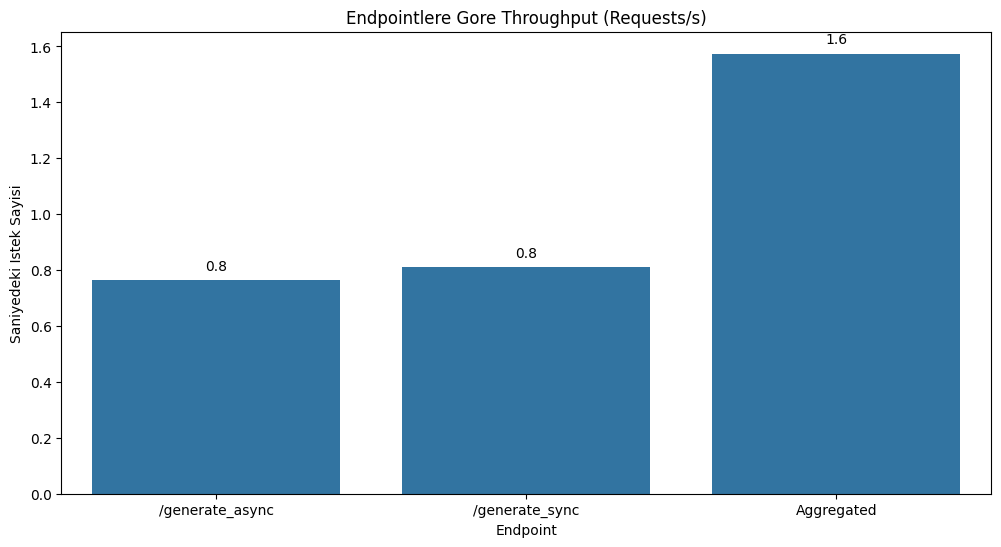


DETAYLI RAPOR OLUSTURULDU (performance_report.json)

ANALIZ TAMAMLANDI! Olusturulan dosyalar:
- throughput_comparison.png
- response_time_distribution.html
- error_types.png (hatalar varsa)
- error_timeline.png (hatalar varsa)
- performance_report.json


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from google.colab import files

# CSV dosyalarını yükleme fonksiyonu
def load_data():
    # Colab'a dosya yükleme
    uploaded = files.upload()
    file_names = list(uploaded.keys())

    # Dosyaları ayır (düzeltilmiş)
    requests_file = [f for f in file_names if 'requests' in f][0]
    failures_file = [f for f in file_names if 'failures' in f][0]
    exceptions_file = [f for f in file_names if 'exceptions' in f][0]

    # Verileri oku
    df_requests = pd.read_csv(requests_file)
    df_failures = pd.read_csv(failures_file)
    df_exceptions = pd.read_csv(exceptions_file)

    return df_requests, df_failures, df_exceptions


# Ana analiz fonksiyonu
def analyze_load_test():
    # Verileri yükle
    requests, failures, exceptions = load_data()

    print("\nTEMEL PERFORMANS ISTATISTIKLERI")
    print(requests[['Name', 'Request Count', 'Failure Count',
                   'Median Response Time', 'Average Response Time',
                   'Requests/s']].to_markdown(index=False))

    print("\nHATA ANALIZI")
    if not failures.empty:
        print(f"Toplam hata sayisi: {len(failures)}")
        print(f"Hata orani: {(len(failures)/requests['Request Count'].sum())*100:.2f}%")
        print("\nEn sik görülen hatalar:")
        print(failures['Error'].value_counts().head(5).to_markdown())
    else:
        print("Test sirasinda hic hata olusmadi.")

    create_visualizations(requests, failures, exceptions)
    generate_detailed_report(requests, failures, exceptions)

# Görselleştirme fonksiyonları
def create_visualizations(requests, failures, exceptions):
    # 1. Throughput Karşılaştırması
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='Name',
        y='Requests/s',
        data=requests,
        estimator=sum,
        ci=None
    )
    plt.title('Endpointlere Gore Throughput (Requests/s)')
    plt.xlabel('Endpoint')
    plt.ylabel('Saniyedeki Istek Sayisi')
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points')
    plt.savefig('throughput_comparison.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    # 2. Yanıt Süresi Dağılımı
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Async Yanit Sureleri", "Sync Yanit Sureleri"))

    async_data = requests[requests['Name'].str.contains('async')]
    sync_data = requests[requests['Name'].str.contains('sync')]

    fig.add_trace(go.Box(
        y=async_data['Average Response Time'],
        name='Async',
        boxpoints='all',
        jitter=0.3,
        pointpos=-1.8,
        marker_color='#1f77b4'
    ), row=1, col=1)

    fig.add_trace(go.Box(
        y=sync_data['Average Response Time'],
        name='Sync',
        boxpoints='all',
        jitter=0.3,
        pointpos=-1.8,
        marker_color='#ff7f0e'
    ), row=1, col=2)

    fig.update_layout(
        title_text="Yanit Süresi Dagilimlari (ms)",
        yaxis_title="Yanit Süresi (ms)",
        showlegend=False
    )
    fig.show()

    # 3. Hata Türleri
    if not failures.empty:
        plt.figure(figsize=(10, 6))
        failures['Error'].value_counts().head(5).plot.pie(
            autopct='%1.1f%%',
            startangle=90,
            wedgeprops={'width': 0.4},
            pctdistance=0.85
        )
        plt.title('Hata Turleri Dagilimi')
        plt.ylabel('')
        plt.savefig('error_types.png', bbox_inches='tight', dpi=300)
        plt.show()
        plt.close()

    # 4. Zaman İçinde Performans
    if 'Timestamp' in exceptions.columns:
        exceptions['Timestamp'] = pd.to_datetime(exceptions['Timestamp'])
        exceptions['Time'] = exceptions['Timestamp'].dt.strftime('%H:%M:%S')

        error_timeline = exceptions.groupby('Time').size().reset_index(name='Count')

        plt.figure(figsize=(12, 6))
        sns.lineplot(
            x='Time',
            y='Count',
            data=error_timeline,
            marker='o',
            color='red'
        )
        plt.title('Zaman Icinde Hata Olusumlari')
        plt.xlabel('Zaman')
        plt.ylabel('Hata Sayisi')
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.savefig('error_timeline.png', bbox_inches='tight', dpi=300)
        plt.show()
        plt.close()

# Detaylı rapor oluşturma
def generate_detailed_report(requests, failures, exceptions):
    report = {
        "test_summary": {
            "total_requests": int(requests['Request Count'].sum()),
            "total_failures": len(failures),
            "error_rate": f"{(len(failures)/requests['Request Count'].sum())*100:.2f}%",
            "test_duration": "Test süresi bilgisi"
        },
        "endpoint_performance": [],
        "recommendations": []
    }

    for _, row in requests.iterrows():
        report["endpoint_performance"].append({
            "endpoint": row['Name'],
            "request_count": int(row['Request Count']),
            "throughput": f"{row['Requests/s']:.2f} req/s",
            "avg_response_time": f"{row['Average Response Time']:.2f} ms",
            "median_response_time": f"{row['Median Response Time']:.2f} ms",
            "failure_count": int(row['Failure Count'])
        })

    async_perf = requests[requests['Name'].str.contains('async')].iloc[0]
    sync_perf = requests[requests['Name'].str.contains('sync')].iloc[0]

    improvement = (sync_perf['Average Response Time'] - async_perf['Average Response Time']) / sync_perf['Average Response Time'] * 100

    report["recommendations"] = [
        f"Async endpoint senkron versiyondan %{improvement:.1f} daha hizli",
        "Yuksek trafikli senaryolarda async kullanimi onerilir",
        "Connection timeout hatalari icin timeout surelerini ayarlayin",
        "500 hatalari icin model yukleme surecini optimize edin"
    ]

    # Raporu JSON olarak kaydet
    with open('performance_report.json', 'w') as f:
        import json
        json.dump(report, f, indent=4)

    print("\nDETAYLI RAPOR OLUSTURULDU (performance_report.json)")

# Çalıştırma
if __name__ == "__main__":
    analyze_load_test()
    print("\nANALIZ TAMAMLANDI! Olusturulan dosyalar:")
    print("- throughput_comparison.png")
    print("- response_time_distribution.html")
    print("- error_types.png (hatalar varsa)")
    print("- error_timeline.png (hatalar varsa)")
    print("- performance_report.json")